In [9]:
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image, ImageOps
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel

# input_image = Image.open("text_diffuser/assets/test01.jpeg").convert("RGB").resize((512,512))
hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')
guidance_scale = 7.5

""" Change the text in the original image by coordinates and  """

sample_text="MLVU Project"
prompt = "a cat"



# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates=[[256, 256]] 
arg_textseg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_hiertext.pth',
    input_size=input_image.size,
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=input_image.size,
    hier_det=True,
)

out = gen_mask_only(input_image, sample_text=sample_text, coordinates=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)


img = out
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
gray = img
_, binary_tss = cv2.threshold(
    gray, 50, 255, cv2.THRESH_BINARY
)


_, binary_bbox = cv2.threshold(
    gray, 200, 255, cv2.THRESH_BINARY
)

binary_tss_pil = Image.fromarray(binary_tss, 'L')
inverted_tss_pil = ImageOps.invert(binary_tss_pil)
binary_bbox_pil = Image.fromarray(binary_bbox, 'L')



Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

Mask shape:  (512, 512)


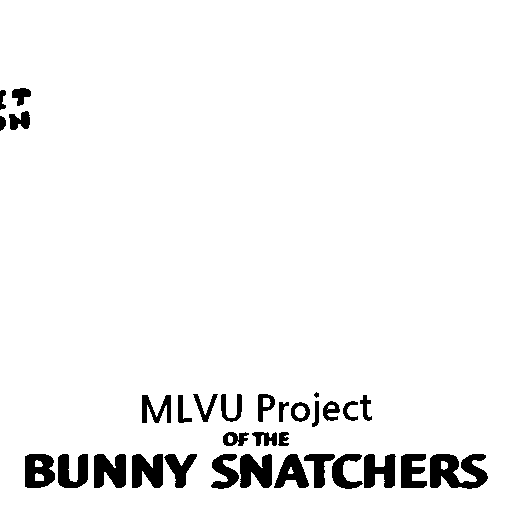

In [2]:
display(binary_tss_pil)

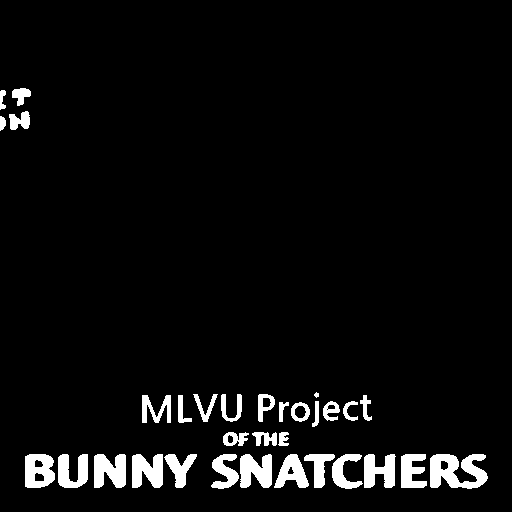

In [3]:
display(inverted_tss_pil)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

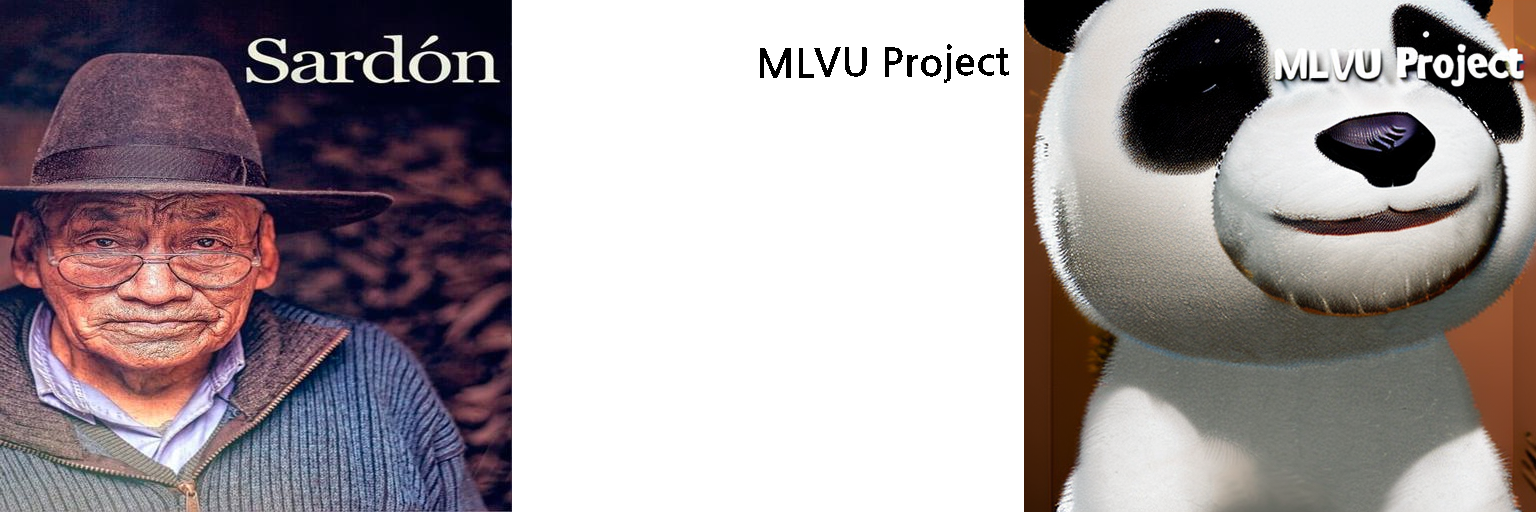

In [62]:
from diffusers import ControlNetModel, EulerAncestralDiscreteScheduler, StableDiffusionControlNetPipeline, UniPCMultistepScheduler
from diffusers.utils import make_image_grid
from PIL import ImageOps

controlnet = ControlNetModel.from_pretrained(
        "GoGiants1/GlyphControls", 
        use_safetensors=True,
        revision="textcaps5K_epoch_40",
        torch_dtype=torch.float16,
        variant="fp16"
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2", 
    controlnet=controlnet, 
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16",
)
controlnet_prompt = prompt + " '" +  sample_text + "'"
# controlnet_prompt = prompt
generator = torch.Generator(device="cpu").manual_seed(42)
pipe.enable_model_cpu_offload()

control_image = Image.fromarray(binary_tss)
output = pipe(
    prompt=controlnet_prompt,
    image=control_image,
    controlnet_conditioning_scale=1.0, 
    generator=generator,
    guidance_scale=guidance_scale,
).images[0]

out_dir = f"experiments/glyph-control/{controlnet_prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/output_cfg_{guidance_scale}.png", "PNG")
control_image.save(f"{out_dir}/control.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")

img = make_image_grid([input_image, control_image, output], rows=1, cols=3)

display(img)

In [63]:
# Text-diffuser without style transfer

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)

pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
generator = torch.Generator(device="cpu").manual_seed(42)
visual_text_prompt = ' "MLVU Project OF THE BUNNY AND SNATCHERS"'
output = pipe(
    prompt=prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

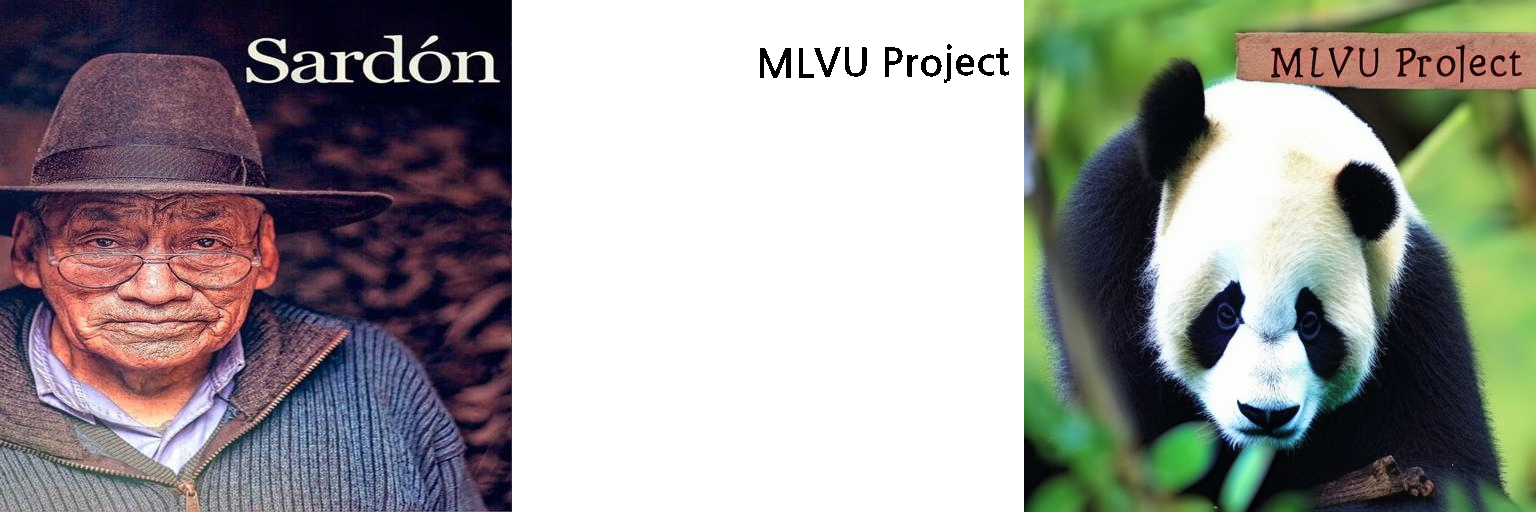

In [64]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)

In [65]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)
pipe.enable_model_cpu_offload()
image = pipe(prompt, guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-base/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
image.save(f"{out_dir}/output.png", "PNG")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

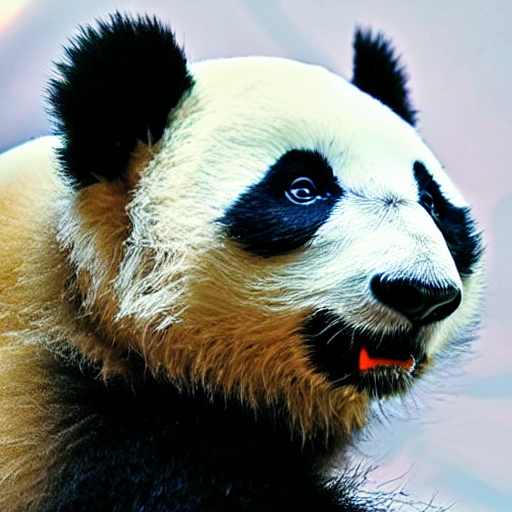

In [66]:
display(image)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

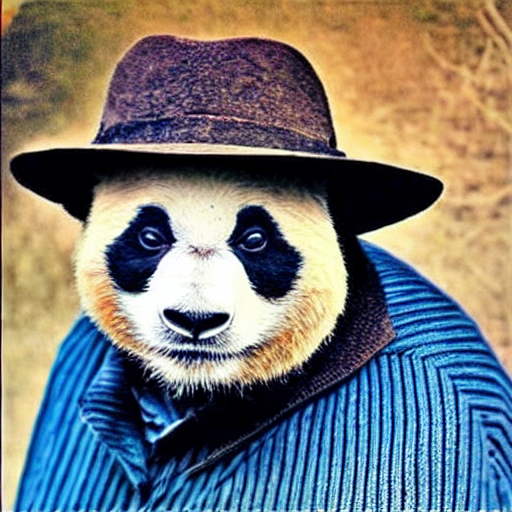

In [83]:
# SD 1.5 + Style Transfer (Naive Version)
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, safety_checker=None, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
    ],
)

pipe.set_ip_adapter_scale(0.5)

pipe.enable_model_cpu_offload()


image = pipe(prompt, ip_adapter_image=[input_image], guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-ip-adapter/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_{block_type}_block{block_idx}_attn{attn_idx}.png", "PNG")
image.save(f"{out_dir}/output_cfg_{guidance_scale}_ip_naive.png", "PNG")
display(image)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

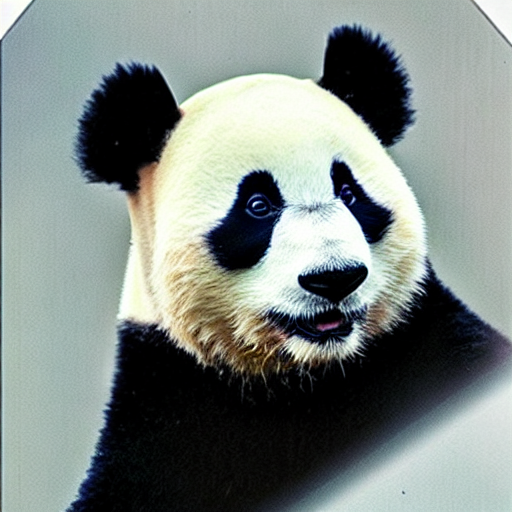

In [72]:
# SD 1.5 + Style Transfer (Without Rendered Text, Use only Style layer)
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, safety_checker=None, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
    ],
)

scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0.5, 0.5],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
}
# block_type = "up"
# block_idx = 3
# attn_idx = 2

# if block_type == "mid":
#     scale[block_type] = 0.7
# else:
#     scale[block_type]["block_" + str(block_idx)][attn_idx]=0.7

# pipe.set_ip_adapter_scale(0.7)
pipe.set_ip_adapter_scale(scale)

pipe.enable_model_cpu_offload()

# hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
# input_image = load_image(hf_dataset_base_url + '3.jpg')

image = pipe(prompt, ip_adapter_image=[input_image], guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-ip-adapter/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_{block_type}_block{block_idx}_attn{attn_idx}.png", "PNG")
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_ip_all.png", "PNG")
image.save(f"{out_dir}/output_optimal_0.5.png", "PNG")
display(image)

In [33]:
"""
scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
"""


def get_file_name_from_scale(scale:dict):
    name = ""
    for k, v in scale.items():
        if k == "mid":
            if v[0] != 0:
                name += "_mid_" + str(v[0])
        else:
            for block_name, block_values in v.items():
                for idx, value in enumerate(block_values):
                    if value != 0:
                        name += f"_{k}_{block_name}_attn{idx}_{value}"
    
    return name

In [12]:
# import cv2
# import numpy as np
# import torch
# from accelerate import PartialState
# from IPython.display import display
# from PIL import Image
# import os
# from attn_map_utils import register_cross_attention_hook
# from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
# from diffusers.utils import load_image
# from hi_sam.text_segmentation import make_text_segmentation_args
# from text_diffuser.generate_mask_only import gen_mask_only
# from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
# from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
# import copy

# # hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
# # input_image = load_image(hf_dataset_base_url + '3.jpg')
# # guidance_scale = 5

# # """ Change the text in the original image by coordinates and  """

# # sample_text="MLVU Team 8"
# # # prompt = "a dog and a cat"
# # prompt = "a dog and a cat"



# # # for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
# # coordinates=[[256, 256]] 
# # arg_textseg = make_text_segmentation_args(
# #     model_type='vit_l',
# #     checkpoint_path='sam_tss_l_hiertext.pth',
# #     input_size=input_image.size,
# #     hier_det=False,
# # )

# # arg_maskgen = make_text_segmentation_args(
# #     model_type='vit_h',
# #     checkpoint_path='word_detection_totaltext.pth',
# #     input_size=input_image.size,
# #     hier_det=True,
# # )

# # out = gen_mask_only(input_image, sample_text=sample_text, coordinates=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)


# # img = out
# # img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
# # gray = img
# # _, binary_tss = cv2.threshold(
# #     gray, 50, 255, cv2.THRESH_BINARY
# # )

# # _, binary_bbox = cv2.threshold(
# #     gray, 200, 255, cv2.THRESH_BINARY
# # )

# # binary_tss_pil = Image.fromarray(binary_tss, 'L')
# # binary_bbox_pil = Image.fromarray(binary_bbox, 'L')

# td_ckpt = "GoGiants1/td-unet15"


# unet = UNet2DConditionModel.from_pretrained(
#     td_ckpt,
#     subfolder="unet",
# )
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

# pipe = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     unet=unet,
#     vae=vae,
#     safety_checker=None,
#     torch_dtype=torch.float32,
# )
# # distributed_state = PartialState()
# # pipe.to(distributed_state.device)


# # pipe.to("cuda")

# pipe.load_ip_adapter(
#     "h94/IP-Adapter",
#     subfolder=[
#         "models",
#     ],
#     weight_name=[
#         # "ip-adapter_sd15.bin",
#         # "ip-adapter_sd15.bin",
#         "ip-adapter-plus_sd15.safetensors",
        
#     ],
#     torch_dtype=torch.float32
# )

# scale = {
#     "down": { 
#         "block_0": [0, 0],
#         "block_1": [0, 0],
#         "block_2": [0, 0],
#     },
#     "mid": [0],
#     "up": {
#         "block_1" : [0,0,0],
#         "block_2" : [0,0,0],
#         "block_3" : [0,0,0]
#     }
    
# }
# blocks = ["down", "mid", "up"]
# block_nums = {
#     "down": range(3),
#     "up": range(1, 4)
# }
# block_max_attn = {
#     "down": 2,
#     "up": 3
# }


# pipe.enable_model_cpu_offload()


# """ Change the text in the original image by coordinates and  """

# text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
# pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# # pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
# generator = torch.Generator(device="cpu").manual_seed(42)

# ip_scale = 0.5

# out_dir = f"experiments/td-15-style-transfer/block-test/{prompt}/ip_scale{ip_scale}"
# if not os.path.exists(out_dir):
#     os.makedirs(out_dir)

# for block in blocks:
#     if block == "mid":
#         scale_copy = copy.deepcopy(scale)
#         scale_copy[block] = ip_scale
#         pipe.set_ip_adapter_scale(scale_copy)
#         output = pipe(
#                     prompt=prompt,
#                     input_image=input_image,
#                     text_mask_image=text_mask_image,
#                     ip_adapter_image=[input_image],
#                     width=512,
#                     height=512,
#                     guidance_scale=guidance_scale,
#                     generator=generator,
#                     torch_dtype=torch.float32
#                 ).images[0]
#         output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{block}_block{block_num}_attn{attn_idx}.png", "PNG")
#     else:
#         for block_num in block_nums[block]:
#             for attn_idx in range(block_max_attn[block]):
#                 scale_copy = copy.deepcopy(scale)
#                 scale_copy[block]["block_" + str(block_num)][attn_idx]=ip_scale
#                 pipe.set_ip_adapter_scale(scale_copy)
            
#                 output = pipe(
#                     prompt=prompt,
#                     input_image=input_image,
#                     text_mask_image=text_mask_image,
#                     ip_adapter_image=[input_image],
#                     width=512,
#                     height=512,
#                     guidance_scale=guidance_scale,
#                     generator=generator,
#                     torch_dtype=torch.float32
#                 ).images[0]
#                 output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{block}_block{block_num}_attn{attn_idx}.png", "PNG")

    


    
# input_image.save(f"{out_dir}/input.png", "PNG")
# binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



In [73]:
"""
scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
"""


def get_file_name_from_scale(scale:dict):
    name = ""
    for k, v in scale.items():
        if k == "mid":
            if v[0] != 0:
                name += "_mid_" + str(v[0])
        else:
            for block_name, block_values in v.items():
                for idx, value in enumerate(block_values):
                    if value != 0:
                        block_idx = block_name.split("_")[-1]
                        name += f"_{k}_{block_idx}_attn{idx}_{value}"
    
    return name

In [86]:
# Our Final Pipeline (TODO: EVAL)

import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy
from datetime import datetime
import json


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter-plus_sd15.safetensors",
    ],
    torch_dtype=torch.float32
)

# style block만 -> 기존 결과물에 애니메이션 스타일만 입히게 되는데 그러면 글자가 깨진다.
# scale_for_bg = {
#     "down": { 
#         "block_0": [0] * 2,
#         "block_1": [0] * 2,
#         "block_2": [0.4, 0], # [0.5, 0] for more prompt, [0.5, 0.5] for more reference
#     },
#     "mid": [0],
#     "up": {
#         "block_1" : [0] * 3,
#         "block_2" : [0, 0, 0],
#         "block_3" : [0, 0, 0]
#     }
# }

bg_scale = 0.5
# 백그라운드 스타일 트랜스퍼 + 공간적 특징
scale_for_bg = {
    "down": {
        "block_0": [bg_scale] * 2,
        "block_1": [bg_scale] * 2,
        "block_2": [bg_scale, bg_scale], # [0.5, 0] for more prompt, [0.5, 0.5] for more reference
    },
    "mid": [bg_scale],
    "up": {
        "block_1" : [bg_scale] * 3,
        "block_2" : [0, 0, 0],
        "block_3" : [0, 0, 0]
    }
}



text_scale = 0.7

scale_for_text = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0, 0, 0],
        "block_2" : [1.0, 1.0, 0],
        "block_3" : [0, 0, 0]
    }
}
pipe.set_ip_adapter_scale([scale_for_bg, scale_for_text])
# pipe.set_ip_adapter_scale([scale, scale])


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
seed = 42
generator = torch.Generator(device="cpu").manual_seed(seed)
visual_text_prompt = ' "MLVU Project OF THE BUNNY AND SNATCHERS"'

# negative_prompt ="ugly, deformed, noisy, blurry, distorted, out of focus, bad anatomy, extra limbs, poorly drawn face, poorly drawn hands, missing fingers, high contrast, over saturated, glossy, Photoshop, sketch, sketches, video game, cgi, canvas frame, signature, username, artist name"
output = pipe(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image,input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}/plus-model"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/{timestamp}.png", "PNG")
scale_info = {
    "background_scale": scale_for_bg,
    "text_scale": scale_for_text,
    "prompt": prompt,
    "guidance_scale": guidance_scale,
    "seed": seed,
    "scheduler": "DDPM"
}
with open(f"{out_dir}/{timestamp}_scale_info.json", 'w') as f:
    json.dump(scale_info, f)

# output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{get_file_name_from_scale(scale)}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 a

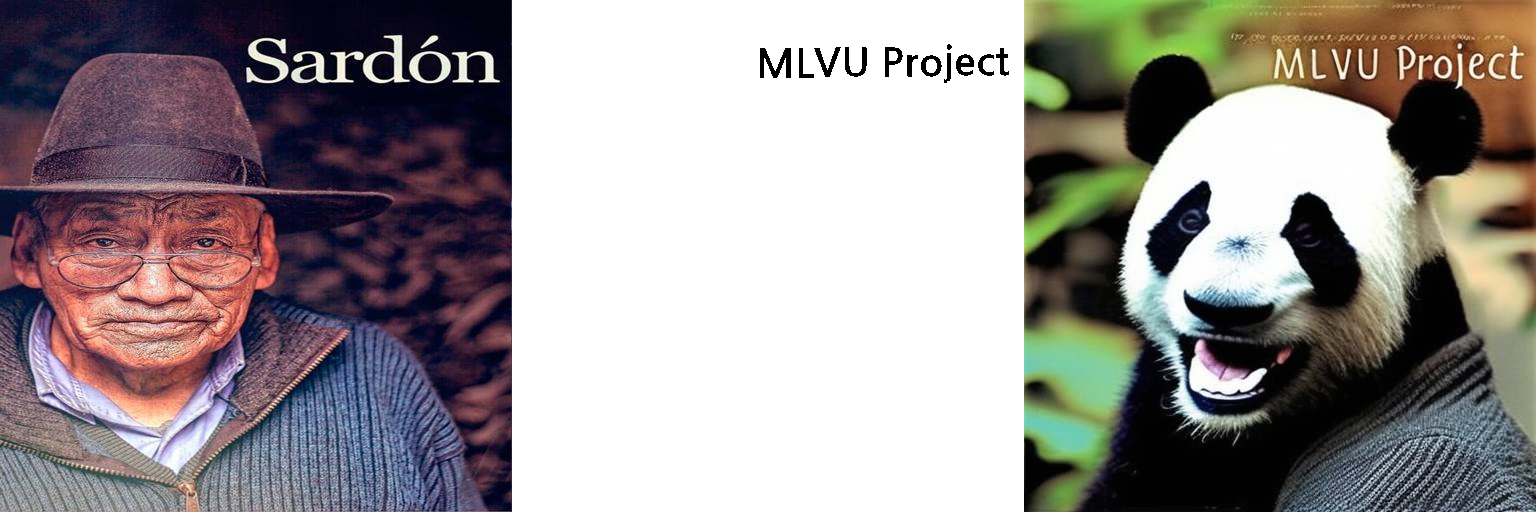

In [87]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)

In [12]:
# Text Diffuser with fine-grained mask (TODO: EVAL)
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy
from datetime import datetime
import json


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)


pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter-plus_sd15.safetensors",
    ],
    torch_dtype=torch.float32
)

pipe.set_ip_adapter_scale([0.5, 0.5])


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
seed = 42
generator = torch.Generator(device="cpu").manual_seed(seed)

# negative_prompt ="ugly, deformed, noisy, blurry, distorted, out of focus, bad anatomy, extra limbs, poorly drawn face, poorly drawn hands, missing fingers, high contrast, over saturated, glossy, Photoshop, sketch, sketches, video game, cgi, canvas frame, signature, username, artist name"
output = pipe(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image, input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}/plus-model/two_masks"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/{timestamp}.png", "PNG")
scale_info = {
    "prompt": prompt,
    "guidance_scale": guidance_scale,
    "seed": seed,
    "scheduler": "DDPM"
}
with open(f"{out_dir}/{timestamp}_scale_info.json", 'w') as f:
    json.dump(scale_info, f)

# output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{get_file_name_from_scale(scale)}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 a

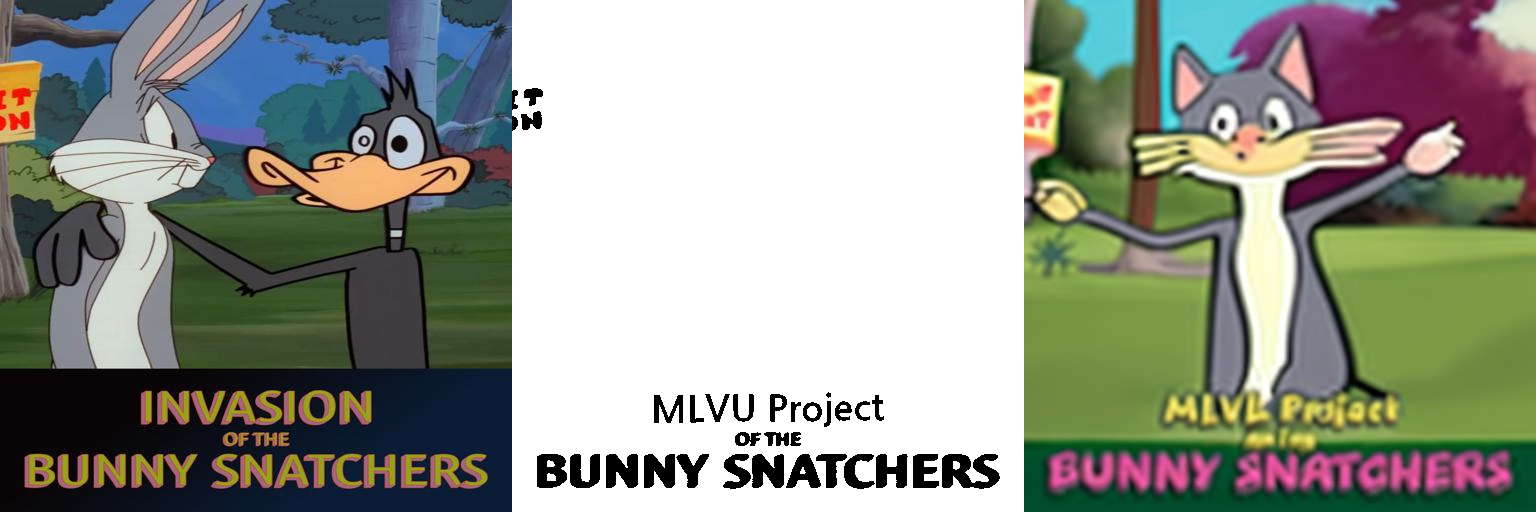

experiments/td-15-style-transfer/a cat/plus-model/two_masks


In [13]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)
print(out_dir)

In [79]:
# Text Diffuser + style transfer without masks (TODO: EVAL)
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy
from datetime import datetime
import json


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
    ],
    torch_dtype=torch.float32
)
bg_scale = 0.25
text_scale = 0.7
scale = {
    "down": {
        "block_0": [bg_scale] * 2,
        "block_1": [bg_scale] * 2,
        "block_2": [bg_scale, bg_scale], # [0.5, 0] for more prompt, [0.5, 0.5] for more reference
    },
    "mid": [bg_scale],
    "up": {
        "block_1" : [bg_scale] * 3,
        "block_2" : [text_scale, 0, 0],
        "block_3" : [text_scale, text_scale, 0]
    }
}
scale = [scale]
pipe.set_ip_adapter_scale(scale)


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
seed = 42
generator = torch.Generator(device="cpu").manual_seed(seed)

# negative_prompt ="ugly, deformed, noisy, blurry, distorted, out of focus, bad anatomy, extra limbs, poorly drawn face, poorly drawn hands, missing fingers, high contrast, over saturated, glossy, Photoshop, sketch, sketches, video game, cgi, canvas frame, signature, username, artist name"
output = pipe(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}/plus-model/one_mask"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/{timestamp}.png", "PNG")
scale_info = {
    "prompt": prompt,
    "guidance_scale": guidance_scale,
    "seed": seed,
    "scale": scale,
    "scheduler": "DDPM"
}
with open(f"{out_dir}/{timestamp}_scale_info.json", 'w') as f:
    json.dump(scale_info, f)

# output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{get_file_name_from_scale(scale)}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

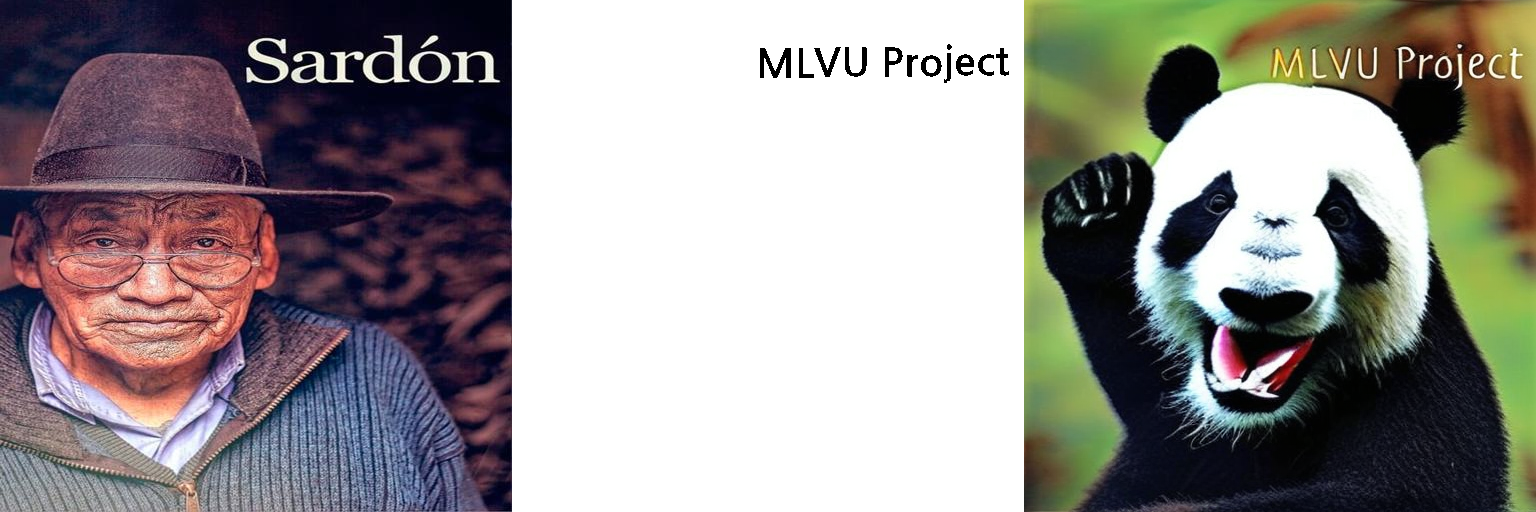

In [80]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)